Ruby Werman <br>
2019

# Cloud labeling


This notebook reads in MOD02 and M0D35 data for a list of dates and generates images. This enables the user to label and save open and closed patches for the purpose of creating input data for a deep learning model. 

## Load Module

In [69]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from pyhdf.SD import SD, SDC
import math

In [8]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'

In [9]:
sys.path.insert(1,os.path.join(sys.path[0],homedir)) # this line helps you to use your own functinos in another directory
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

In [23]:
#returns the coded date in the format of year, and days after January 1st
#e.g. January 1, 2001 -- > 2001015
def get_coded_date(date):
    """
    returns the coded date in "YYYYDDD" format
    
    Inputs: 
    date: a date in "YYYY-MM-DD" format
    
    Outputs:
    a string in "YYYYDDD" format
    """
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    leap_years = [2000, 2004, 2008, 2012, 2015]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:])
    days = day
    if month != 1:
        calendar = days_per_month
        if year in leap_years:
            calendar = days_per_month_leap
        for m in range(month - 1):
            days += calendar[m]
    return str(year * 1000 + days)

### Load dates 

In [51]:
# enter name of text file containing the dates
file_name = "/home/rubywerman/clouds/src_analysis/dates/label1.txt"
text_file = open(file_name, "r")
dates = text_file.read().split('\n')

The `Picture` object makes it simple to store the date, MOD02, and MOD35 data for each date

In [10]:
class Picture:
    def __init__(self, date, mod02_patches, vhdf_array, plot):
        self.date = date
        self.mod02_patches = mod02_patches
        self.vhdf_array = vhdf_array
        self.plot = plot
picture_dict = {}

The following function is used to load in the MOD02, MOD35, and coded date from your directories

In [35]:
#select directory path for given date
def get_data(d):
    """
    returns a tuple containing the directory path for the mod02, mod35 data, and the coded data
    
    Inputs:
    d: a string of the date in the format of "YYYY-MM-DD"
    
    Outputs:
    tuple of the mod02 data directory, mod35 data directory, and the date in the format of "YYYYDDD"
    """
    #return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))
    hdir = '/home/tkurihana/scratch-midway2/clouds/analysis_mod021KM/data'
    return (hdir+'/MOD02/', hdir+'/MOD35/', '2015335' )
    #get_coded_date(d))

## Generate image

The following function `generate_image(d)` takes in a date and creates a cloud image using MOD02 and MOD35 data. The function also adds the image to a dictionary of cloud images. Red squares overlay the image, noting patches that have over .5 percent cloud coverage (this threshold can be changed below by editing the value of `thres`. 

The generate_image function displays the patches for a given date's cloud data and also saves the relevant mod02 and mod35 data into `pictures_dict`. The function returns all the patch coordinates and the vhdf_array data and the mod02_img

In [121]:
%matplotlib inline
def generate_image(d):
    #load in the MOD02, MOD35, and coded date for the given date
        """
        Creates images for each patch in a given date's photo where cloud coverage is above the threshold (currently .5)
    
        Inputs:
        d: a string representing a date in the format "YYYY-MM-DD"
    
        Outputs: 
        list_pics: a list of coordinates for each patch image produced 
        vhdf_array: a numpy array containing mod35 data, necessary for producing the image
        mod02_img: a numpy array containing mod02 data

        """
    #try:
        mod02_hdfdir, mod35_hdfdir, date = get_data(d)

        ### genetate numpy array for mod02, mod35 data
        mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
        clouds_mask_img = gen_mod35_img_single(hdf_datadir=mod35_hdfdir, date=date)

        # generate patch
        ## NO normalization to preserve original radiance strength 
        mod02_patches = _gen_patches(mod02_img, normalization=False)

        # cloud patches with at least ${thres} percent of cloud flag within patch
        thres = 0.3 # range [0.0 - 1.0] floating points. 0.3 is optimal
        clouds_patches_list, clouds_xy_list = const_clouds_array(mod02_patches, clouds_mask_img, thres=thres)

        # reconstruct img array from list
        ix, iy = mod02_patches.shape[:2]
        cimg_array = np.zeros((ix,iy)).astype(np.float64)
        cimg_array[:,:] = np.nan
        for idx, (x,y) in enumerate(clouds_xy_list):
            cimg_array[x,y] = 0  # input is 0 if there is a cloud (0 corresponds to color-list index afterwords)

        # load visible band (band 1 out of 36)
        hdf_datadir = mod02_hdfdir
        vis_file = glob.glob(
                hdf_datadir+'/MOD021KM.A'+date+'.mosaic.061.*.EV_250_Aggr1km_RefSB_1.hdf'
            )[0]

        # get hdf data  
        vhdf = SD(vis_file, SDC.READ)

        # get sds (science data structure) data
        vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

        # the vhdf_array data is essential in recreating the image
        vhdf_array, vis_band = mod02_proc_sds_single(vhdf_sds)
        patches   = mod02_patches
        img_array = cimg_array

        print("Create Patch Index in Entire Satellite Imagery", flush=True)
        aix = []
        for x in range(patches.shape[0]):
            x1 = x
            x2 = x1 + 1
            for y in range(patches.shape[1]):
                y1 = y
                y2 = y1 + 1
                if not np.isnan(img_array[x,y]):
                    aix.append([[y1, y2, x1, x2], True])
                else:
                    aix.append([[y1,y2,x1,x2], False])

        list_pics = []
        for i in range(patches.shape[0]*patches.shape[1]):
            p = aix[i][0]
            if aix[i][1]:
                list_pics.append(aix[i][0])
        
        print("\n Start Plotting \n", flush=True)
        #rows = columns = math.ceil(math.sqrt(len(list_pics))) 
        rows, columns = patches.shape[0], patches.shape[1]
        fig, axarr = plt.subplots(rows,columns, figsize=(20,20))
        #plt.subplots_adjust(hspace=.5)
        arr_iter = iter(list_pics)
        nums = iter(range(len(list_pics)))
        s = 128
        for r in range(rows):
            for c in range(columns):       
                try:
                    y1,y2,x1,x2 = next(arr_iter)
                    axarr[x1,y1].imshow(vhdf_array[s*x1:s*x2,s*y1:s*y2])
                    #axarr[r,c].set_title('%d'%(next(nums)), fontsize=15)
                except StopIteration:
                        pass
                #if c == 0:
                    #axarr[r,0].set_ylabel( "{}".format(r), fontsize=15)
                if r == 0:
                    axarr[0,c].set_title( "{}".format(c), fontsize=15)
                #axarr[r,c].axis('off')
                # Turn off tick labels
                axarr[r,c].set_yticklabels([])
                axarr[r,c].set_xticklabels([])
            axarr[r,0].set_ylabel( "{}".format(r), fontsize=15,rotation=0)
        plt.show() 
        return list_pics, vhdf_array, mod02_img
    #except:
    #    print("OOB Error")
    #    return 

The following cell iterates through the date list, generates the cloud images broken into patches. 

## Data Collection

The following cells are labeled patch data that is waiting to be exported– my kernel kept shutting down need to fix why. 

In [38]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))

Create an empty `patch_list` to collect all the open and closed patches to be exported

In [39]:
patch_list = []

Select a date to label, and run the cell below to generate the image

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 1
Create Patch Index in Entire Satellite Imagery

 Start Plotting 



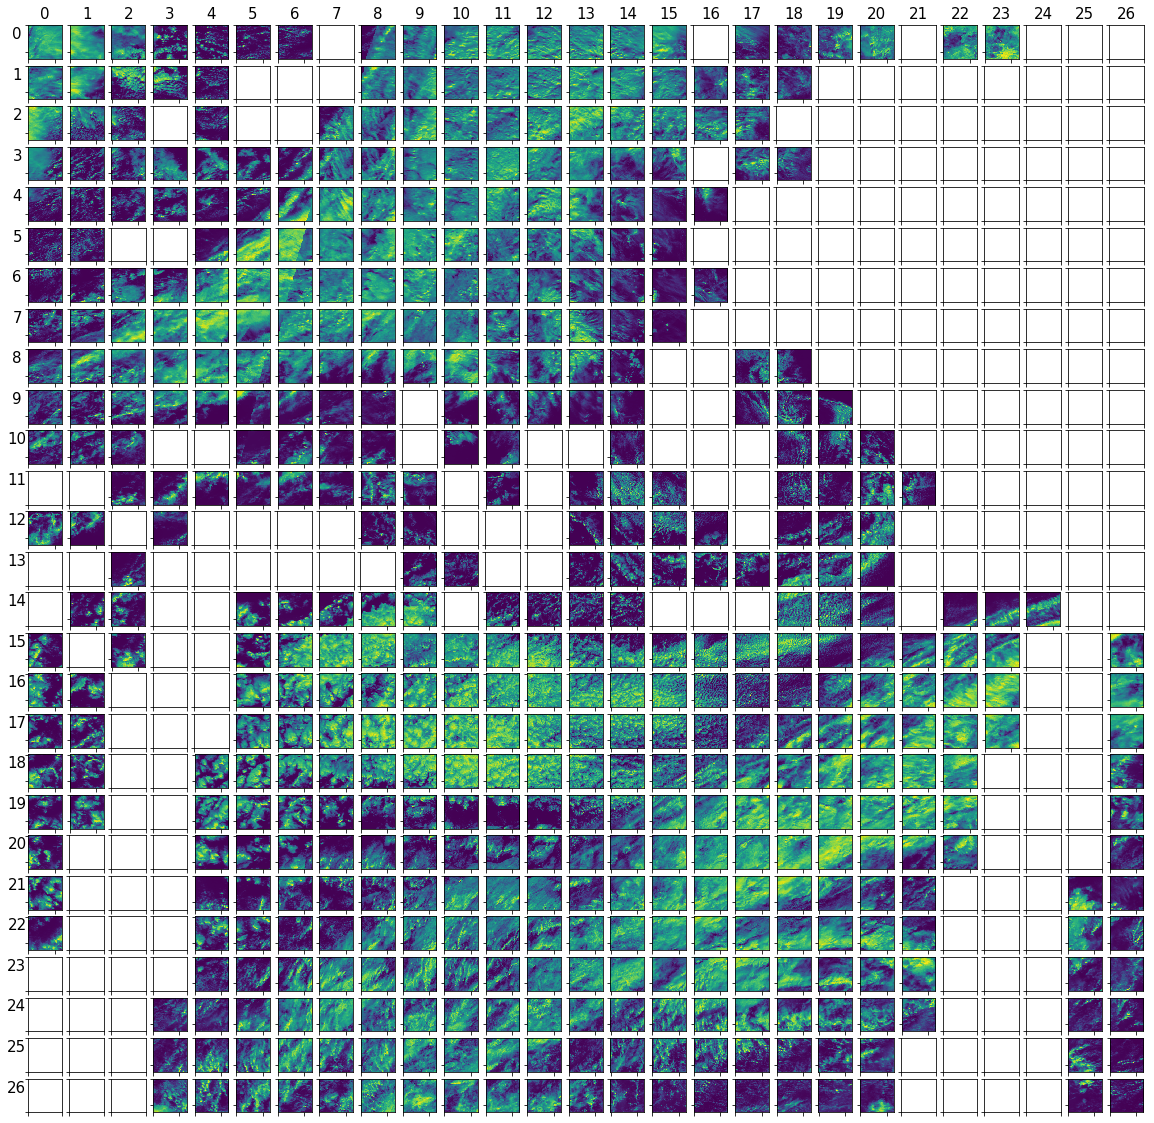

In [122]:
pic_date = "2015335"
just_one_dates_pics, vhdf_array, mod02_img = generate_image(pic_date)

In [79]:
vhdf_array.shape

(3562, 3540)

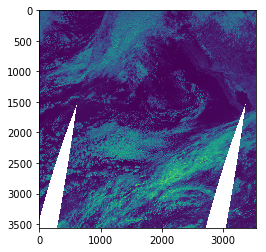

In [80]:
plt.imshow(vhdf_array)

Write the indices for open patches in `open_patches`, and closed patches in `closed_patches`

In [ ]:
open_patches = []
closed_patches = [42]

In [71]:
open_coords = [just_one_dates_pics[i] for i in open_patches] #coords data
closed_coords = [just_one_dates_pics[i] for i in closed_patches] #coords data

for p in range(len(open_patches)):
    patch_list.append(Patch(pic_date, True, vhdf_array, mod02_img, None, None, True, open_coords[p]))
for p in range(len(closed_patches)):
    patch_list.append(Patch(pic_date, False, vhdf_array, mod02_img, None, None, False, closed_coords[p]))

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 1


<Figure size 1440x1440 with 0 Axes>

Update mod02 patch data to contain data in the correct format

In [340]:
for p in patch_list:
    p.zeroTwo = _gen_patches(p.zeroTwo[p.coords[0]*128:p.coords[1]*128, p.coords[2]*128:p.coords[3]*128], normalization=False)

### Output data 

Run the cell below to save the patch list to a file. Update the file name to today's date

In [342]:
np.save('/home/rubywerman/clouds/src_analysis/labeled_data/class_patch_data/072219.npy', patch_list)